In [14]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4PytChem as t4p

/home/romuald/ENSEIGNEMENT/0-JupyterNotebooks/PytChem


**Start at:** Sunday 05 February 2023, 18:27:32  
**Hostname:** ip-sw-install-nico.insa-toulouse.fr (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/logoPytChem.svg" style="margin-left:auto; margin-right:auto"/></p>

# VUV simulation from TDDFT calculations

## Test case

$$\varepsilon_{i}(\bar{\nu})=\varepsilon_{i}^{\mathrm{max}}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$
It is demonstrated, in a [Gaussian whitepaper](https://gaussian.com/uvvisplot/), that the previous equation becomes, in the cgs units system:
$$\varepsilon_{i}(\bar{\nu})=\frac{\sqrt{\pi}e^{2}N_{\mathrm{A}}}{1000\ln(10)c^{2}m_{e}}\frac{f_{i}}{\sigma}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$

where:
- $\varepsilon_i$ is in units of L∙mol$^{-1}$∙cm$^{-1}$
- $f_i$ is the oscillator strength
- $\sigma$, the half-width of the Gaussian band at each $\varepsilon^{\mathrm{max}}$, is in cm$^{-1}$
- $c$ is the speed of light in cm∙s$^{-1}$
- $N_\mathrm{A}$ is the Avogadro number, in mol$^{-1}$
- $m_e$ is the electron mass in kg
- $e$ is the elementary charge, in electrostatic unit of charge (esu)
- $f_i$ is the dimensionless oscillator strength

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

c = sc.c*1e3 #cm-1
NA = sc.N_A #mol-1
me = sc.m_e #kg
e = sc.e*sc.c*10 #elementary charge in esu 
print(c,NA,me,e)
#calculation of the pre-factor
pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
print(f"{pf:8e}")

sigma = 0.4 #eV this the default value in GaussView
eV2cm1 = sc.e / (sc.h * sc.c *100)
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
print("eV to cm-1",eV2cm1)
print("eV to nm",eV2nm)

sigmanm = eV2nm/sigma
print("sigma = ", sigma ,"eV ->",sigmanm," nm")

def epsi(lambdaX,lambdai,fi,sigma):
    '''
    input:
        - lambdaX = wavelength variable, in nm
        - lambdai = vertical excitation wavelength for ith state, in nm
        - fi = oscillator strength for state i (dimensionless)
        - sigma = half-width of the Gaussian band, in nm
    output :
        molar absorption coefficient, in L mol-1 cm-1
    '''
    import scipy.constants as sc
    c = sc.c*1e3 #cm-1
    NA = sc.N_A #mol-1
    me = sc.m_e #kg
    e = sc.e*sc.c*10 #elementary charge in esu 
    pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
    nubarX = 1e7 / lambdaX # nm to cm-1
    nubari = 1e7 / lambdai
    sigmabar = 1e7 / sigma 
    epsi = pf * (fi / sigmabar) * np.exp(-((nubarX - nubari)/sigmabar)**2)
    return epsi

299792458000.0 6.02214076e+23 9.1093837015e-31 4.803204712570263e-10
1.306297e+09
eV to cm-1 8065.543937349212
eV to nm 1239.8419843320028
sigma =  0.4 eV -> 3099.604960830007  nm


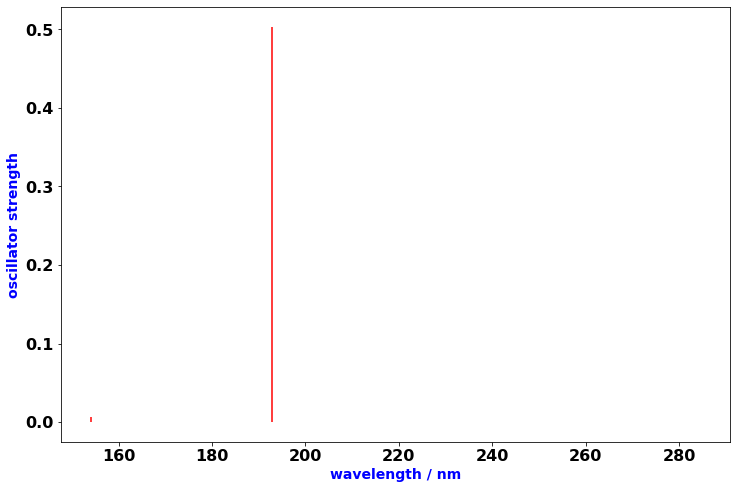

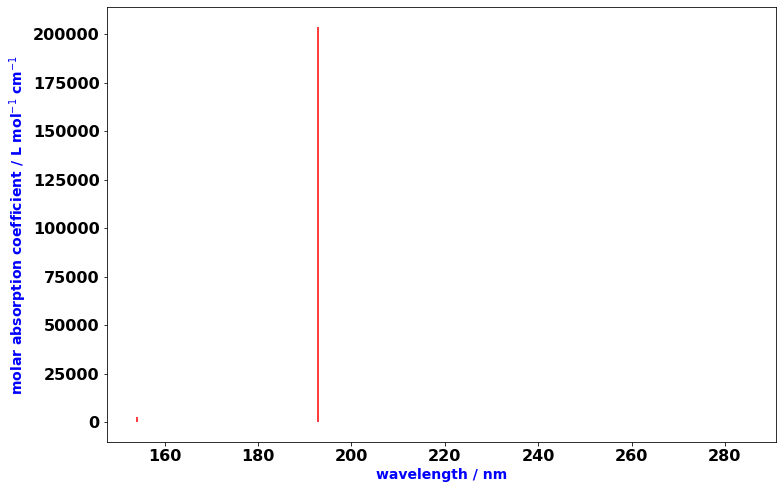

In [16]:
wavel = [154.07,192.80,284.45]
fe = [0.0061,0.5035,0.0002]
plt.figure(figsize=(12,8))
for i in range(len(wavel)):
    plt.vlines(x = wavel[i], ymin = 0, ymax = fe[i], colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('oscillator strength',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.show()

plt.figure(figsize=(12,8))
for i in range(len(wavel)):
    plt.vlines(x = wavel[i], ymin = 0, ymax = epsi(wavel[i],wavel[i],fe[i],sigmanm), colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.show()

In [17]:
lambdaL = np.arange(100,301,1)
sumf = np.zeros(len(lambdaL))
k = -1
for l in lambdaL:
    k += 1
    for i in range(len(wavel)):
        sumf[np.argwhere(l==lambdaL)[0][0]] += epsi(l,wavel[i],fe[i],sigmanm)


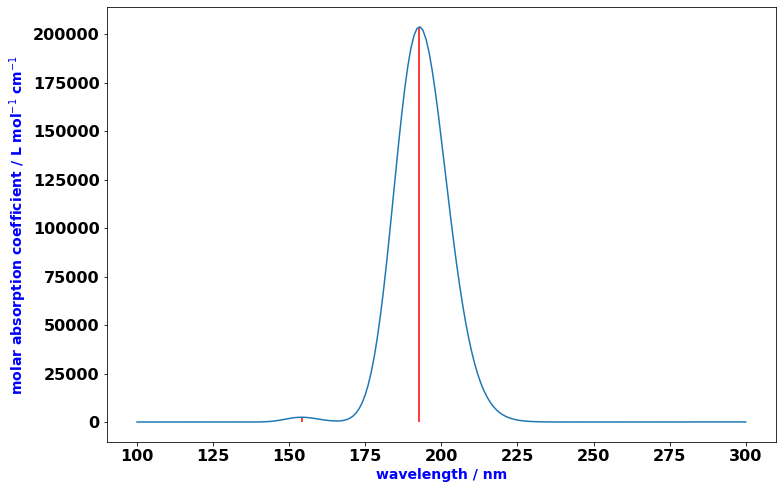

In [18]:
plt.figure(figsize=(12,8))
for i in range(len(wavel)):
    plt.vlines(x = wavel[i], ymin = 0, ymax = epsi(wavel[i],wavel[i],fe[i],sigmanm), colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(lambdaL,sumf)
plt.show()

## Application

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

sigma = 100 #eV this the default value in GaussView
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
sigmanm = eV2nm/sigma
print("sigma = ", sigma ,"eV ->",sigmanm," nm")

def epsi(lambdaX,lambdai,fi,sigmanm):
    '''
    input:
        - lambdaX = wavelength variable, in nm
        - lambdai = vertical excitation wavelength for ith state, in nm
        - fi = oscillator strength for state i (dimensionless)
        - sigma = half-width of the Gaussian band, in nm
    output :
        molar absorption coefficient, in L mol-1 cm-1
    '''
    import scipy.constants as sc
    c = sc.c*1e3 #cm-1
    NA = sc.N_A #mol-1
    me = sc.m_e #kg
    e = sc.e*sc.c*10 #elementary charge in esu 
    pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
    nubarX = 1e7 / lambdaX # nm to cm-1
    nubari = 1e7 / lambdai
    sigmabar = 1e7 / sigma 
    epsi = pf * (fi / sigmabar) * np.exp(-((nubarX - nubari)/sigmabar)**2)
    return epsi

sigma =  100 eV -> 12.398419843320028  nm


In [64]:
istate,state,wavel,fe,SSq = np.genfromtxt("./MiscData/Nethanol-tddft-transitions.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
lambdaL = np.arange(200,601,1)
sumf = np.zeros(len(lambdaL))
for l in lambdaL:
    for i in range(len(wavel)):
        sumf[np.argwhere(l==lambdaL)[0][0]] += epsi(l,wavel[i],fe[i],sigmanm)

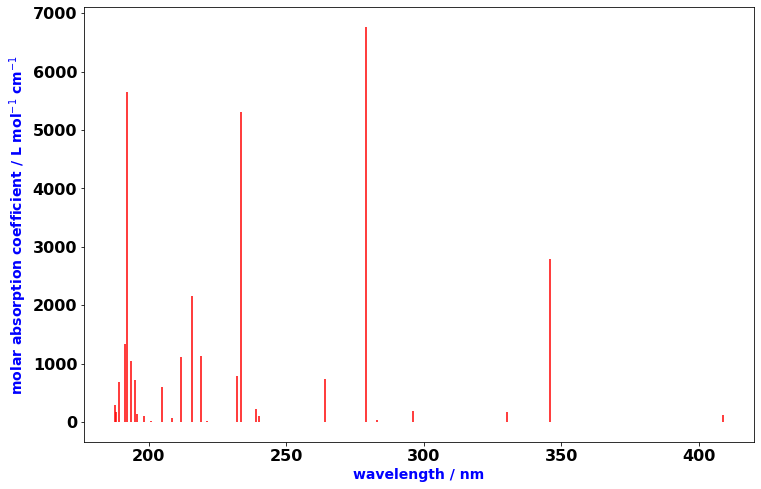

In [65]:
plt.figure(figsize=(12,8))
for i in range(len(wavel)):
    plt.vlines(x = wavel[i], ymin = 0, ymax = epsi(wavel[i],wavel[i],fe[i],sigmanm), colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.show()

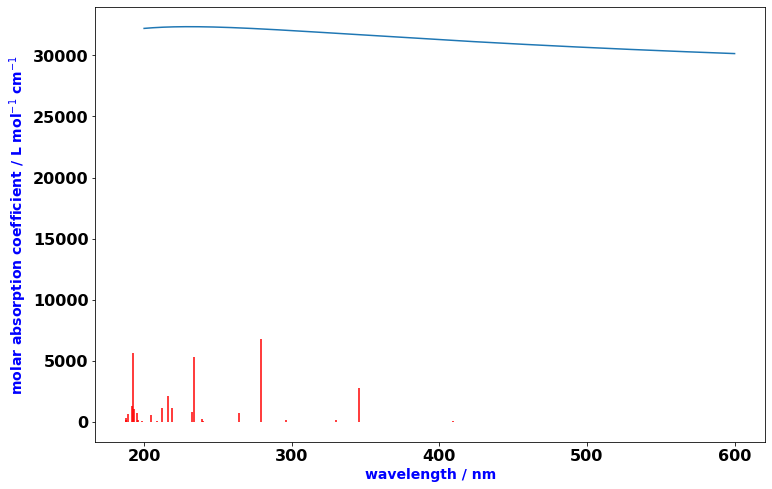

In [66]:
plt.figure(figsize=(12,8))
for i in range(len(wavel)):
    plt.vlines(x = wavel[i], ymin = 0, ymax = epsi(wavel[i],wavel[i],fe[i],sigmanm), colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(lambdaL,sumf)
plt.show()

## Simple version

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

def epsi(lambdaX,lambdai,fi,sigma):
    '''
    input:
        - lambdaX = wavelength
        - lambdai = vertical excitation wavelength for ith state
        - fi = oscillator strength for state i (dimensionless)
        - sigma = half-width of the Gaussian band
    output :
        gaussian distribution
    '''
    epsi = (fi / (sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((lambdaX - lambdai)/sigma)**2)
    return epsi

In [102]:
istateN,stateN,wavelN,feN,SSqN = np.genfromtxt("./MiscData/NacetonitrileTDDFT-LBS.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
istateMC,stateMC,wavelMC,feMC,SSqMC = np.genfromtxt("./MiscData/MCacetonitrileTDDFT-LBS.csv",skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
sigma = 15

lambdaL = np.arange(200,601,1)
sumfN = np.zeros(len(lambdaL))
sumfMC = np.zeros(len(lambdaL))
for l in lambdaL:
    for i in range(len(wavel)):
        sumfN[np.argwhere(l==lambdaL)[0][0]] += epsi(l,wavelN[i],feN[i],sigma)
        sumfMC[np.argwhere(l==lambdaL)[0][0]] += epsi(l,wavelMC[i],feMC[i],sigma)

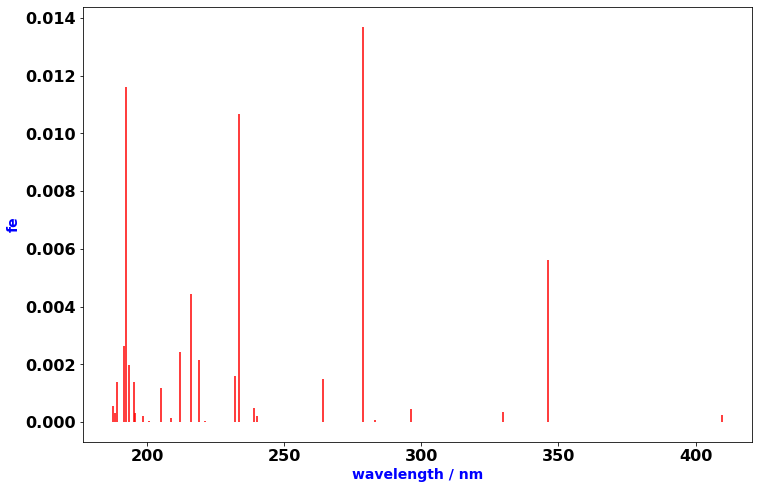

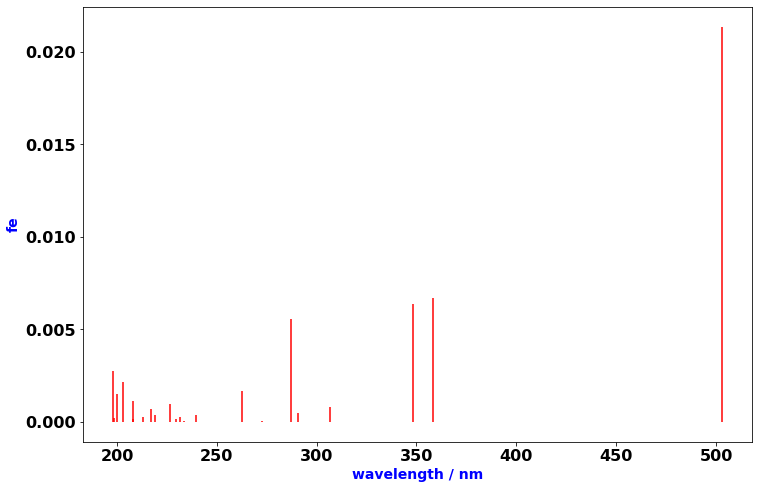

In [110]:
plt.figure(figsize=(12,8))
for i in range(len(wavelN)):
    plt.vlines(x = wavelN[i], ymin = 0, ymax = epsi(wavelN[i],wavelN[i],feN[i],sigma), colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('fe',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.show()
plt.figure(figsize=(12,8))
for i in range(len(wavelMC)):
    plt.vlines(x = wavelMC[i], ymin = 0, ymax = epsi(wavelMC[i],wavelMC[i],feMC[i],sigma), colors = 'red')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('fe',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.show()

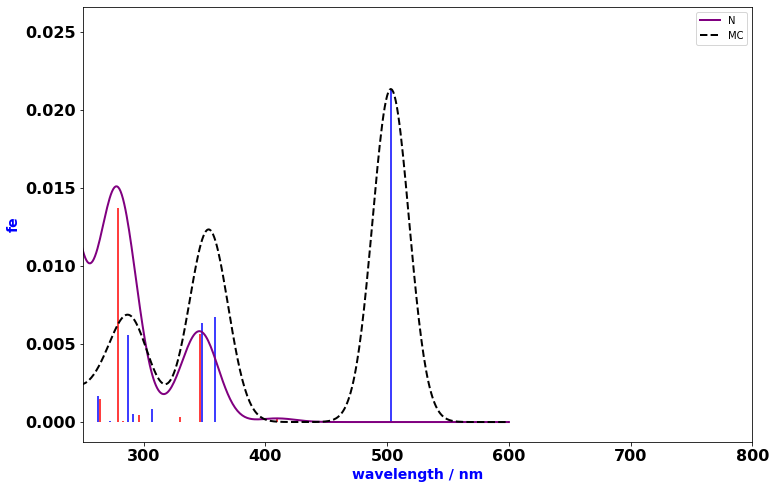

In [112]:
plt.figure(figsize=(12,8))
for i in range(len(wavelN)):
    plt.vlines(x = wavelN[i], ymin = 0, ymax = epsi(wavelN[i],wavelN[i],feN[i],sigma), colors = 'red')
for i in range(len(wavelN)):
    plt.vlines(x = wavelMC[i], ymin = 0, ymax = epsi(wavelMC[i],wavelMC[i],feMC[i],sigma), colors = 'blue')
plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='blue')
plt.ylabel('fe',size=14,fontweight='bold',color='blue')
plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(fontsize=16,fontweight='bold')
plt.plot(lambdaL,sumfN,color='purple',linewidth=2,label="N")
plt.plot(lambdaL,sumfMC,color='black',linewidth=2,linestyle='--',label="MC")
plt.xlim(250,800)
plt.legend()
plt.show()